# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/AIML/lab_internal_residency9')
#os.chdir('/content/drive/My Drive')


In [0]:
IMAGE_DIR = "images_racoon/images/"
TRAIN_CSV = "train_labels.csv"

### Load the training data from train.csv file

In [0]:
df_data = pd.read_csv(TRAIN_CSV)

In [95]:
df_data.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [96]:
df_data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
        if(col != 0 ):   
            index = 0
            row_values = []
            for i, r in enumerate(row[0:8]): # Parse row with seven entities
                if(i!=0 and i!=3): 
                    row_values.append(int(r))
                elif(i==0):
                    paths.append(r)

            image_height, image_width, x0, y0, x1, y1 = row_values  
            coords[col-1, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
            coords[col-1, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
            coords[col-1, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
            coords[col-1, 3] = (y1 - y0) * IMAGE_SIZE / image_height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [99]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open('{}{}'.format(IMAGE_DIR,f)) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
    
print("batch_images size: ",len(batch_images))

batch_images size:  173


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
# Compile the model with Adam optimizer with smaller learning rate 
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

In [104]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [105]:
model.fit(batch_images,gt,
            epochs=30,batch_size = 32)


Epoch 1/30
173/173 [==============================] - 5s 31ms/step - loss: 3624.7149 - IoU: 0.0611
Epoch 2/30
173/173 [==============================] - 5s 26ms/step - loss: 1173.6395 - IoU: 0.3340
Epoch 3/30
173/173 [==============================] - 5s 26ms/step - loss: 906.5735 - IoU: 0.4000
Epoch 4/30
173/173 [==============================] - 5s 26ms/step - loss: 878.1723 - IoU: 0.4432
Epoch 5/30
173/173 [==============================] - 5s 26ms/step - loss: 615.4874 - IoU: 0.5065
Epoch 6/30
173/173 [==============================] - 5s 26ms/step - loss: 503.7602 - IoU: 0.5220
Epoch 7/30
173/173 [==============================] - 5s 26ms/step - loss: 448.6183 - IoU: 0.5460
Epoch 8/30
173/173 [==============================] - 5s 26ms/step - loss: 372.2696 - IoU: 0.5796
Epoch 9/30
173/173 [==============================] - 5s 26ms/step - loss: 317.7248 - IoU: 0.6130
Epoch 10/30
173/173 [==============================] - 5s 27ms/step - loss: 291.1434 - IoU: 0.6221
Epoch 11/30
173/1

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = 'raccoon-182.jpg'
unscaled = cv2.imread("{}{}".format(IMAGE_DIR,filename)) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

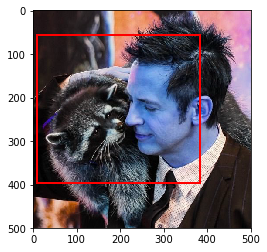

In [109]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
#NA

#### Change your present working directory

In [0]:
#NA

### Load your data file

In [166]:
TEMP_CSV = "daily-minimum-temperatures-in-me.csv"

temperarure_df=pd.read_csv(TEMP_CSV)
temperarure_df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [167]:
temperarure_df.shape

(3650, 2)

#### Plot data

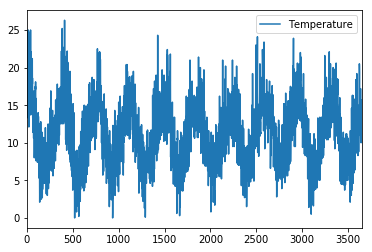

In [168]:
temperarure_df.plot()

#### Descibe your dataframe

In [169]:
temperarure_df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [170]:
temperarure_df.isnull().sum()

Date           0
Temperature    0
dtype: int64

In [0]:
## no null values 

#### Drop null values

In [0]:
#NA

#### Get the representation of the distribution of data in the form of histogram

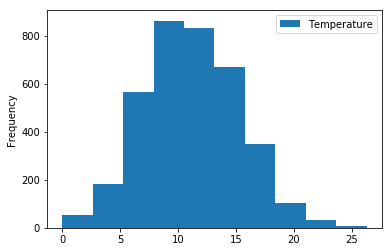

In [173]:
temperarure_df.plot(kind='Hist')

#### Check the maximum and minimum values

In [174]:
temp_min = temperarure_df["Temperature"].min()
temp_max = temperarure_df["Temperature"].max()
print('Minimum Temperature: ',temp_min)
print('Max Temperature: ',temp_max)

Minimum Temperature:  0.0
Max Temperature:  26.3


### Normalize the data

In [175]:
columns_to_keep = ['Temperature']
temperarure_df = temperarure_df[columns_to_keep]
temperarure_df['Temperature'] = temperarure_df['Temperature'].apply(lambda x: x*1000)
temperarure_df.index.names = ['Month']
temperarure_df.sort_index(inplace=True)
print('Total rows: {}'.format(len(temperarure_df)))
temperarure_df.head()

Total rows: 3650


,Temperature
Month,
0,20700.0
1,17900.0
2,18800.0
3,14600.0
4,15800.0


In [0]:
dataset = temperarure_df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [177]:
temp_min = scaled.min()
temp_max = scaled.max()
print('Minimum Temperature: ',temp_min)
print('Max Temperature: ',temp_max)

Minimum Temperature:  0.0
Max Temperature:  1.0


#### Look into some of the scaled values

In [178]:
scaled[0:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Split data into Training and Testing

In [0]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [181]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [183]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190115
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749049
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642586
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490495
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673004
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254753
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [184]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [186]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [187]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 6s - loss: 0.0193
Epoch 2/20
 - 4s - loss: 0.0148
Epoch 3/20
 - 4s - loss: 0.0135
Epoch 4/20
 - 4s - loss: 0.0120
Epoch 5/20
 - 4s - loss: 0.0116
Epoch 6/20
 - 4s - loss: 0.0116
Epoch 7/20
 - 4s - loss: 0.0111
Epoch 8/20
 - 4s - loss: 0.0106
Epoch 9/20
 - 4s - loss: 0.0105
Epoch 10/20
 - 4s - loss: 0.0104
Epoch 11/20
 - 4s - loss: 0.0104
Epoch 12/20
 - 4s - loss: 0.0103
Epoch 13/20
 - 4s - loss: 0.0103
Epoch 14/20
 - 4s - loss: 0.0103
Epoch 15/20
 - 4s - loss: 0.0103
Epoch 16/20
 - 4s - loss: 0.0103
Epoch 17/20
 - 4s - loss: 0.0102
Epoch 18/20
 - 4s - loss: 0.0102
Epoch 19/20
 - 4s - loss: 0.0102
Epoch 20/20
 - 4s - loss: 0.0102


## Make Predictions and Evaluate your model

In [188]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2605.62 RMSE
Test Score: 2444.82 RMSE


## Plot the results

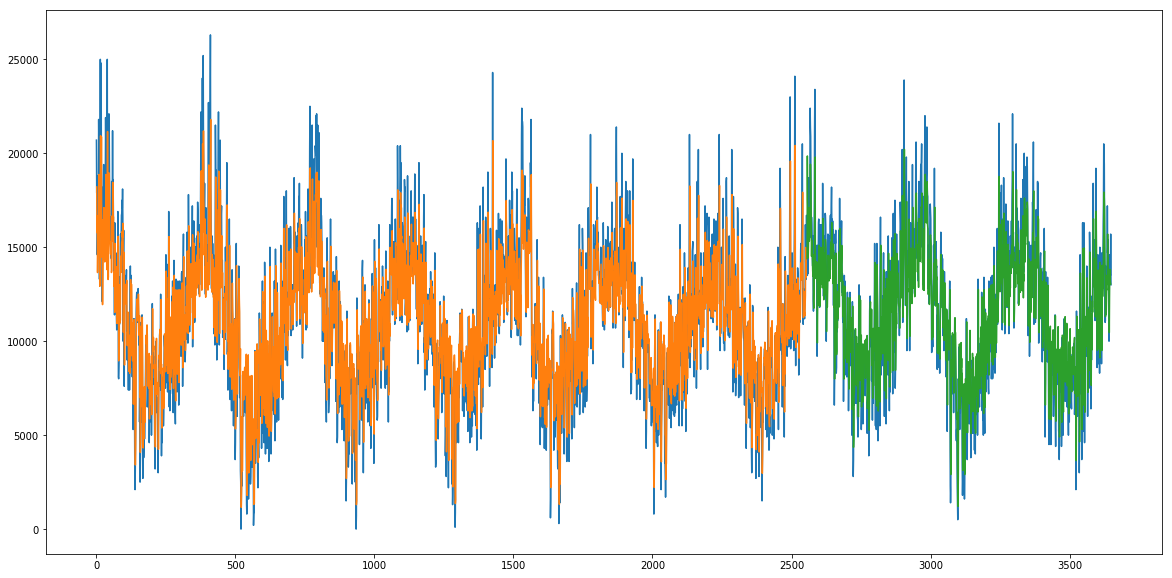

In [189]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()